In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(os.path.normpath(SRC_DIR))

import platform
import operator
import itertools
import datetime as dt

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
from IPython.display import display

from pipeline import JHU, CTP, NYT, DPC
from utils import write_csv, ISO_3166_2

seaborn.set(palette='pastel')
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

print("python", platform.python_version())
print("pandas", pd.__version__)

python 3.8.2
pandas 1.0.3


## data sources

In [3]:
kwargs = dict(verbose=False)
CATALOG = {
    'jhu': JHU(**kwargs).clean,
    'ctp': CTP(**kwargs).clean,
    'nyt': NYT(**kwargs).clean,
    'dpc': DPC(**kwargs).clean,
}

for name, df in CATALOG.items():
    display(f'preview: {name}', df.tail(3))

'preview: jhu'

,date,country_region,province_state,admin2,confirmed,deaths,recovered,last_update,_province_state
31025,2020-03-28,West Bank and Gaza,West Bank and Gaza,West Bank and Gaza,98.0,1.0,18.0,2020-03-28 23:05:25,[None]
31026,2020-03-28,Zambia,Zambia,Zambia,28.0,0.0,0.0,2020-03-28 23:05:25,[None]
31027,2020-03-28,Zimbabwe,Zimbabwe,Zimbabwe,7.0,1.0,0.0,2020-03-28 23:05:25,[None]


'preview: ctp'

,date,state,positive,negative,pending,hospitalized,death,total,hash,date_checked,total_test_results,fips,death_increase,hospitalized_increase,negative_increase,positive_increase,total_test_results_increase
1314,2020-03-29,West Virginia,113.0,2705.0,0.0,1.0,0.0,2818,626ca2fdd89b005a3d3b606376e4ac5fd2a4772c,2020-03-29 20:00:00+00:00,2818,54,0.0,0.0,374.0,17.0,391.0
1315,2020-03-29,Wisconsin,1112.0,16550.0,NaN,NaN,13.0,17662,2cd5d65e6cf10a667f00fe96ffd78eb850713129,2020-03-29 20:00:00+00:00,17662,55,0.0,0.0,1318.0,123.0,1441.0
1316,2020-03-29,Wyoming,86.0,1554.0,NaN,15.0,0.0,1640,e6365afc2c29afd4168c8d82cd57312427281140,2020-03-29 20:00:00+00:00,1640,56,0.0,1.0,79.0,4.0,83.0


'preview: nyt'

,date,county,state,fips,cases,deaths
17728,2020-03-28,Sweetwater,Wyoming,56037,1,0
17729,2020-03-28,Teton,Wyoming,56039,14,0
17730,2020-03-28,Washakie,Wyoming,56043,1,0


'preview: dpc'

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,date
732,2020-03-29 17:00:00,ITA,18,Calabria,38.905976,16.594402,124,19,143,434,577,54,12,25,614,8485,NaN,NaN,2020-03-29
733,2020-03-29 17:00:00,ITA,19,Sicilia,38.115697,13.362357,451,71,522,808,1330,88,65,65,1460,13814,NaN,NaN,2020-03-29
734,2020-03-29 17:00:00,ITA,20,Sardegna,39.215312,9.110616,105,23,128,454,582,13,29,27,638,4598,NaN,NaN,2020-03-29


## ontology

In [4]:
METRICS = ['cases', 'deaths', 'recovered']
LIMITS = dict(zip(METRICS, [100, 10, 10]))
LEVELS = ['country', 'state', 'county']
SOURCES = {
    'jhu': 'Johns Hopkins University',
    'nyt': 'The New York Times',
    'dpc': 'Dipartimento della Protezione Civile',
}


def rollup(df, level):
    df = df.copy()
    if level == 'county':
        return df

    agg_level = ['date', 'day', 'country']

    if level == 'state':
        gdf = df.groupby([*agg_level, 'state'])
    else:
        gdf = df.groupby(agg_level)

    return (
        gdf
        .agg({**dict(zip(METRICS, [sum, sum, sum])),
              'source': set})
        .assign(source=lambda df: df['source'].map(lambda x: ','.join(x)))
        .reset_index()
    )


def levels_in_df(df):
    return [l for l in LEVELS if l in df.columns]


### combined

In [5]:
COLS = [
    'date',
    *LEVELS,
    *METRICS,
    'updated',
    'source',
]

nyt_dates = CATALOG['nyt']['date'].drop_duplicates().values
dpc_dates = CATALOG['dpc']['date'].drop_duplicates().values

df = pd.concat([

    CATALOG['jhu'].copy()
    .rename(columns={
        'country_region': 'country',
        'province_state': 'state',
        'admin2': 'county',
        'confirmed': 'cases',
    })
    # all data except US data in NYT
    .loc[lambda df: (df['country'] != 'US') | ~df['date'].isin(nyt_dates)]
    # all data except Italy data in DPC
    .loc[lambda df: (df['country'] != 'Italy') | ~df['date'].isin(dpc_dates)]
    .assign(
        updated=lambda df: df['last_update'].fillna(df['date']),
        source='jhu'
    )
    [COLS],

    # US metrics from NYT
    CATALOG['nyt'].copy()
    .assign(
        country='US',
        recovered=np.nan,
        source='nyt',
        updated=lambda df: df['date'],
    )
    [COLS],
    
    # Italy metrics from DPC
    CATALOG['dpc'].copy()
    .rename(columns={
        'denominazione_regione': 'state',
        'totale_casi': 'cases',
        'deceduti': 'deaths',
        'dimessi_guariti': 'recovered',
        'data': 'updated',
    })
    .assign(
        country='Italy',
        county=lambda df: df['state'],
        source='dpc',
    )
    [COLS]
])


df = (
    df
    .assign(
        day=lambda df: df['date'].dt.strftime('%Y-%m-%d'),
        cases=lambda df: df['cases'].fillna(0),
    )
    .loc[lambda df: df['cases'] > 0]  # only non-zero cases interesting
    .sort_values(['date', *LEVELS])
    .reset_index(drop=True)
)

write_csv(df.drop(['day'], axis=1).replace(SOURCES), 'covid19-combined.csv')
CATALOG['df.combined'] = df
display('sources', df['source'].value_counts())
display('preview', df.tail())

'sources'

nyt    17731
jhu     7559
dpc      662
Name: source, dtype: int64

'preview'

,date,country,state,county,cases,deaths,recovered,updated,source,day
25947,2020-03-29,Italy,Sicilia,Sicilia,1460.0,65.0,65.0,2020-03-29 17:00:00,dpc,2020-03-29
25948,2020-03-29,Italy,Toscana,Toscana,4122.0,215.0,121.0,2020-03-29 17:00:00,dpc,2020-03-29
25949,2020-03-29,Italy,Umbria,Umbria,1023.0,31.0,95.0,2020-03-29 17:00:00,dpc,2020-03-29
25950,2020-03-29,Italy,Valle d'Aosta,Valle d'Aosta,584.0,43.0,2.0,2020-03-29 17:00:00,dpc,2020-03-29
25951,2020-03-29,Italy,Veneto,Veneto,8358.0,392.0,715.0,2020-03-29 17:00:00,dpc,2020-03-29


### derived

In [6]:
def with_cases_active(df):
    df['cases_active'] = (
        df['cases'].fillna(0)
        - df['deaths'].fillna(0)
        - df['recovered'].fillna(0)
    )
    return df


def with_cfr(df):
    df['cfr'] = 100 * (df['deaths'].fillna(0) / df['cases'])
    return df


def with_diffs(df):
    agg_level = levels_in_df(df)
    df[[f"{m}_new" for m in METRICS]] = (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .diff()
    )
    return df


def with_pct_change(df):
    agg_level = levels_in_df(df)
    df[[f"{m}_pct_change" for m in METRICS]] = 100 * (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .pct_change()
    )
    return df

In [7]:
for i, level in enumerate(LEVELS):
    df = (
        rollup(CATALOG['df.combined'], level)
        .pipe(with_cases_active)
        .pipe(with_cfr)
        .pipe(with_diffs)
        .pipe(with_pct_change)
    )
    CATALOG[f'df.derived.{level}'] = df

df = CATALOG['df.derived.county']
df = df.loc[df['state'] == 'Lombardia']
display('preview', df.tail())

'preview'

,date,country,state,county,cases,deaths,recovered,updated,source,day,cases_active,cfr,cases_new,deaths_new,recovered_new,cases_pct_change,deaths_pct_change,recovered_pct_change
18128,2020-03-25,Italy,Lombardia,Lombardia,32346.0,4474.0,7281.0,2020-03-25 17:00:00,dpc,2020-03-25,20591.0,13.831695,1643.0,296.0,624.0,5.351269,7.084730,9.373592
19929,2020-03-26,Italy,Lombardia,Lombardia,34889.0,4861.0,7839.0,2020-03-26 17:00:00,dpc,2020-03-26,22189.0,13.932758,2543.0,387.0,558.0,7.861869,8.649978,7.663782
21863,2020-03-27,Italy,Lombardia,Lombardia,37298.0,5402.0,8001.0,2020-03-27 17:00:00,dpc,2020-03-27,23895.0,14.483350,2409.0,541.0,162.0,6.904755,11.129397,2.066590
23918,2020-03-28,Italy,Lombardia,Lombardia,39415.0,5944.0,8962.0,2020-03-28 17:00:00,dpc,2020-03-28,24509.0,15.080553,2117.0,542.0,961.0,5.675908,10.033321,12.010999
25939,2020-03-29,Italy,Lombardia,Lombardia,41007.0,6360.0,9255.0,2020-03-29 17:00:00,dpc,2020-03-29,25392.0,15.509547,1592.0,416.0,293.0,4.039071,6.998654,3.269360


### offset

In [8]:
def with_offset(df, metric, limit=100):
    col = f"{metric}_offset"
    agg_level = levels_in_df(df)
    df[col] = (
        df
        .copy()
        .loc[df[metric] >= limit]
        .sort_values([*agg_level, 'date', 'day'])
        .groupby(agg_level)[metric]
        .cumcount()
    )
    return df


def reindex_offset(df, offset):
    agg_level = levels_in_df(df)
    df = (
        df
        .copy()
        .dropna(subset=[offset])
        .set_index([offset, 'offset_metric', *agg_level])
        .reset_index()
    )
    return df


In [9]:
for i, level in enumerate(LEVELS):
    df = CATALOG[f'df.derived.{level}'].copy()
    id_vals = df.columns.values
    df = (
        df
        .pipe(with_offset, 'cases', LIMITS['cases'])
        .pipe(with_offset, 'deaths', LIMITS['deaths'])
        .pipe(with_offset, 'recovered', LIMITS['recovered'])
        .melt(
            id_vals,
            [f'{m}_offset' for m in METRICS],
            'offset_metric',
            'offset'
        )
        .replace(r"_offset$", '', regex=True)
        .pipe(reindex_offset, 'offset')
    )
    CATALOG[f'df.offset.{level}'] = df

df = CATALOG['df.offset.state']
df = df.loc[(df['state'] == 'Lombardia')
            & (df['offset_metric'] == 'cases')]
display('preview', df.tail())

'preview'

,offset,offset_metric,country,state,date,day,cases,deaths,recovered,source,cases_active,cfr,cases_new,deaths_new,recovered_new,cases_pct_change,deaths_pct_change,recovered_pct_change
2924,30.0,cases,Italy,Lombardia,2020-03-25,2020-03-25,32346.0,4474.0,7281.0,dpc,20591.0,13.831695,1643.0,296.0,624.0,5.351269,7.084730,9.373592
3109,31.0,cases,Italy,Lombardia,2020-03-26,2020-03-26,34889.0,4861.0,7839.0,dpc,22189.0,13.932758,2543.0,387.0,558.0,7.861869,8.649978,7.663782
3303,32.0,cases,Italy,Lombardia,2020-03-27,2020-03-27,37298.0,5402.0,8001.0,dpc,23895.0,14.483350,2409.0,541.0,162.0,6.904755,11.129397,2.066590
3503,33.0,cases,Italy,Lombardia,2020-03-28,2020-03-28,39415.0,5944.0,8962.0,dpc,24509.0,15.080553,2117.0,542.0,961.0,5.675908,10.033321,12.010999
3625,34.0,cases,Italy,Lombardia,2020-03-29,2020-03-29,41007.0,6360.0,9255.0,dpc,25392.0,15.509547,1592.0,416.0,293.0,4.039071,6.998654,3.269360


## visualization

### overview

In [10]:
# filter to latest date and significant impact
df = CATALOG['df.derived.country'].copy()
levels = levels_in_df(df)
df = (
    df
    .sort_values([*levels, 'date'])
    .groupby(levels)
    .last()
    .reset_index()
    .query(f'cases >= {LIMITS["cases"]}')
)

def prettify(df):
    for m in [*METRICS, 'cases_active', *[f'{m}_new' for m in METRICS]]:
        df[m] = df[m].map(lambda x: f"{x:,.0f}")
    for m in ['cfr', *[f'{m}_pct_change' for m in METRICS]]:
        df[m] = df[m].map(lambda x: f"{x:,.1f}")
    if 'state' in df.columns:
        df.loc[df['country'] == df['state'], 'state'] = ''
    if 'county' in df.columns:
        df.loc[df['country'] == df['county'], 'county'] = ''
    return df.drop(['day'], axis=1)

display(
    "totals",
    df[METRICS]
    .sum()
    .rename('total')
    .map(lambda x: f"{x:,.0f}")
    .to_frame()
)

idx = ['date', 'source', *levels, *METRICS]
display(
    "regions with most cases",
    prettify(df.sort_values('cases', ascending=False))
    [idx]
    .reset_index(drop=True)
    .head(10)
)
display(
    "regions fastest growing, regions with 500 or more new cases/day",
    prettify(df.query('cases_new > 500')
               .sort_values('cases_pct_change', ascending=False))
    [[*idx, 'cases_new', 'cases_pct_change']]
    .reset_index(drop=True)
    .head(10)
)

'totals'

,total
cases,"667,633"
deaths,"31,502"
recovered,"139,058"


'regions with most cases'

,date,source,country,cases,deaths,recovered
0,2020-03-28,nyt,US,"123,618","2,140",0
1,2020-03-29,dpc,Italy,"97,689","10,779","13,030"
2,2020-03-28,jhu,China,"81,999","3,299","75,100"
3,2020-03-28,jhu,Spain,"73,235","5,982","12,285"
4,2020-03-28,jhu,Germany,"57,695",433,"8,481"
5,2020-03-28,jhu,France,"38,105","2,317","5,724"
6,2020-03-28,jhu,Iran,"35,408","2,517","11,679"
7,2020-03-28,jhu,UK,"17,312","1,021",151
8,2020-03-28,jhu,Switzerland,"14,076",264,"1,530"
9,2020-03-28,jhu,Netherlands,"9,819",640,6


'regions fastest growing, regions with 500 or more new cases/day'

,date,source,country,cases,deaths,recovered,cases_new,cases_pct_change
0,2020-03-28,jhu,Turkey,"7,402",108,70,"1,704",29.9
1,2020-03-28,jhu,Belgium,"9,134",353,"1,063","1,850",25.4
2,2020-03-28,jhu,Portugal,"5,170",100,43,902,21.1
3,2020-03-28,nyt,US,"123,618","2,140",0,"20,705",20.1
4,2020-03-28,jhu,Israel,"3,619",12,89,584,19.2
5,2020-03-28,jhu,Canada,"5,576",60,0,894,19.1
6,2020-03-28,jhu,UK,"17,312","1,021",151,"2,567",17.4
7,2020-03-28,jhu,France,"38,105","2,317","5,724","4,703",14.1
8,2020-03-28,jhu,Netherlands,"9,819",640,6,"1,172",13.6
9,2020-03-28,jhu,Germany,"57,695",433,"8,481","6,824",13.4


## timeseries

In [11]:
def infotext(size):
    if size == 'long':
        sources = SOURCES.values()
    else:
        sources = map(lambda s: s.upper(), SOURCES.keys())
    return f"updated: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}\n" \
           f"sources: {', '.join(sources)}"


def set_yaxis(ax):
    def formatter(number, pos=None):
        """Convert a number into a human readable format."""
        magnitude = 0
        while abs(number) >= 1000:
            magnitude += 1
            number /= 1000.0
        decimals = 1 if number < 1 else 0
        return f"{number:,.{decimals}f}{['', 'k', 'M', 'B'][magnitude]}"

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
    
    # human readable y scale ticks
    ymin, ymax = ax.get_ylim()
    ticks = map(lambda x: (x, 2 * x, 5 * x), ax.get_yticks())
    ticks = itertools.chain(*ticks)
    ticks = list(filter(lambda y: (y > ymin) & (y < ymax), ticks))[1:]
    if len(ticks) > 10:
        ticks = ticks[2:]
    ax.set_yticks(ticks)

    
def set_data_labels(ax, values, series):
    # skip trailing NaNs
    values = values.loc[:values.last_valid_index()].values
    for i, v in enumerate(values):
        # plot when i has same parity as number of elements
        # e.g. for 20 values, want to plot odd numbered values
        # to ensure i=19 (last element) is annotated
        if ((len(values) % 2) == ((i + 1) % 2)) & (v > 0):
            frmt = f'{v:,.1f}' if series in ['cfr'] else f'{v:,.0f}'
            bbox = dict(pad=0.5, facecolor='white', alpha=0.5)
            ax.text(i, v, frmt, ha='left', va='top', fontsize=7, bbox=bbox)


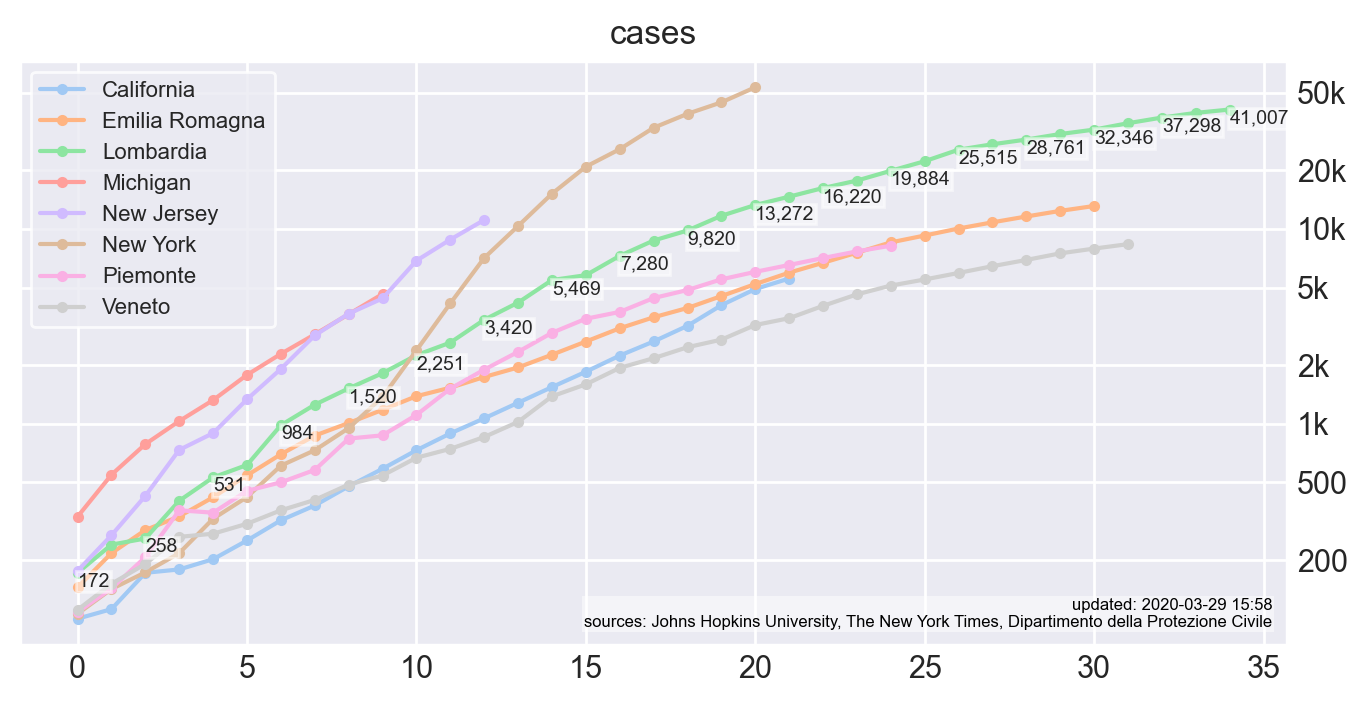

In [18]:
def get_timeseries(series, metric, offset_metric):
    dfs = {}
    for level, config in series.items():
        df = config['df'].copy()

        # county names may clash with state names so deconflict
        if level == 'county':
            df['_state'] = df['state'].replace(ISO_3166_2)
            df['county'] = df[['county', '_state']].agg(', '.join, axis=1)
            df = df.drop(['_state'], axis=1)

        filter_level = config.get('series_level', level)
        df = (
            df
            .loc[lambda df: df['offset_metric'] == offset_metric]
            .loc[lambda df: df[filter_level].isin(config['series'])]
        )
        
        if 'state' not in df.columns:
            df['state'] = df['country']
        if 'county' not in df.columns:
            df['county'] = df['state']
        dfs[level] = df

    df = pd.concat(dfs)
    # coalesce(county, state, country)
    df['region'] = df['county'].fillna(df['state']).fillna(df['country'])
    df = df.pivot(index='offset', columns='region', values=metric)
    return df


def plot(series, plots, highlight='Italy', dpi=100):
    
    days = 36
    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    rows = len(plots)
    fig, axs = plt.subplots(rows, 1, figsize=(7, rows * 4), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        metric, offset_metric = t
        ax = axs[i] if rows > 1 else axs

        ts = get_timeseries(series, metric, offset_metric)[:days]
        ts.plot(title=metric, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        set_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        
        # data labels
        set_data_labels(ax, ts[highlight], series)

        # info text box
        props = dict(color='black', fontsize=6, multialignment='right')
        box = AnchoredText(infotext('long'), loc=4, frameon=True, pad=0.1,
                           borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=2, prop={'size':8})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if rows > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


plot(
    series={
#         'country': {
#             'df': CATALOG['df.offset.country'],
#             'series': ['US', 'Italy'],
#         },
        'state': {
            'df': CATALOG['df.offset.state'],
            'series': ['New York', 'New Jersey', 'California', 'Michigan',
                       'Lombardia', 'Emilia Romagna', 'Veneto', 'Piemonte'],
#             'series': ['Italy'],
#             'series_level': 'country',
        },
#         'county': {
#             'df': CATALOG['df.offset.county'],
#             'series': [
#                 'New York City, NY', 'Westchester, NY', 'Nassau, NY',
#                 'Los Angeles, CA', 'Santa Clara, CA', 'San Francisco, CA',
#             ],
# #             'series': ['California'],
# #             'series_level': 'state',
#         }
    },
    plots={  # k = metric to plot; v = offset_metric index to use
        'cases': 'cases',
#         'deaths': 'deaths',
#         'cases_new': 'cases',
    },
    **dict(highlight='Lombardia', dpi=200),
)

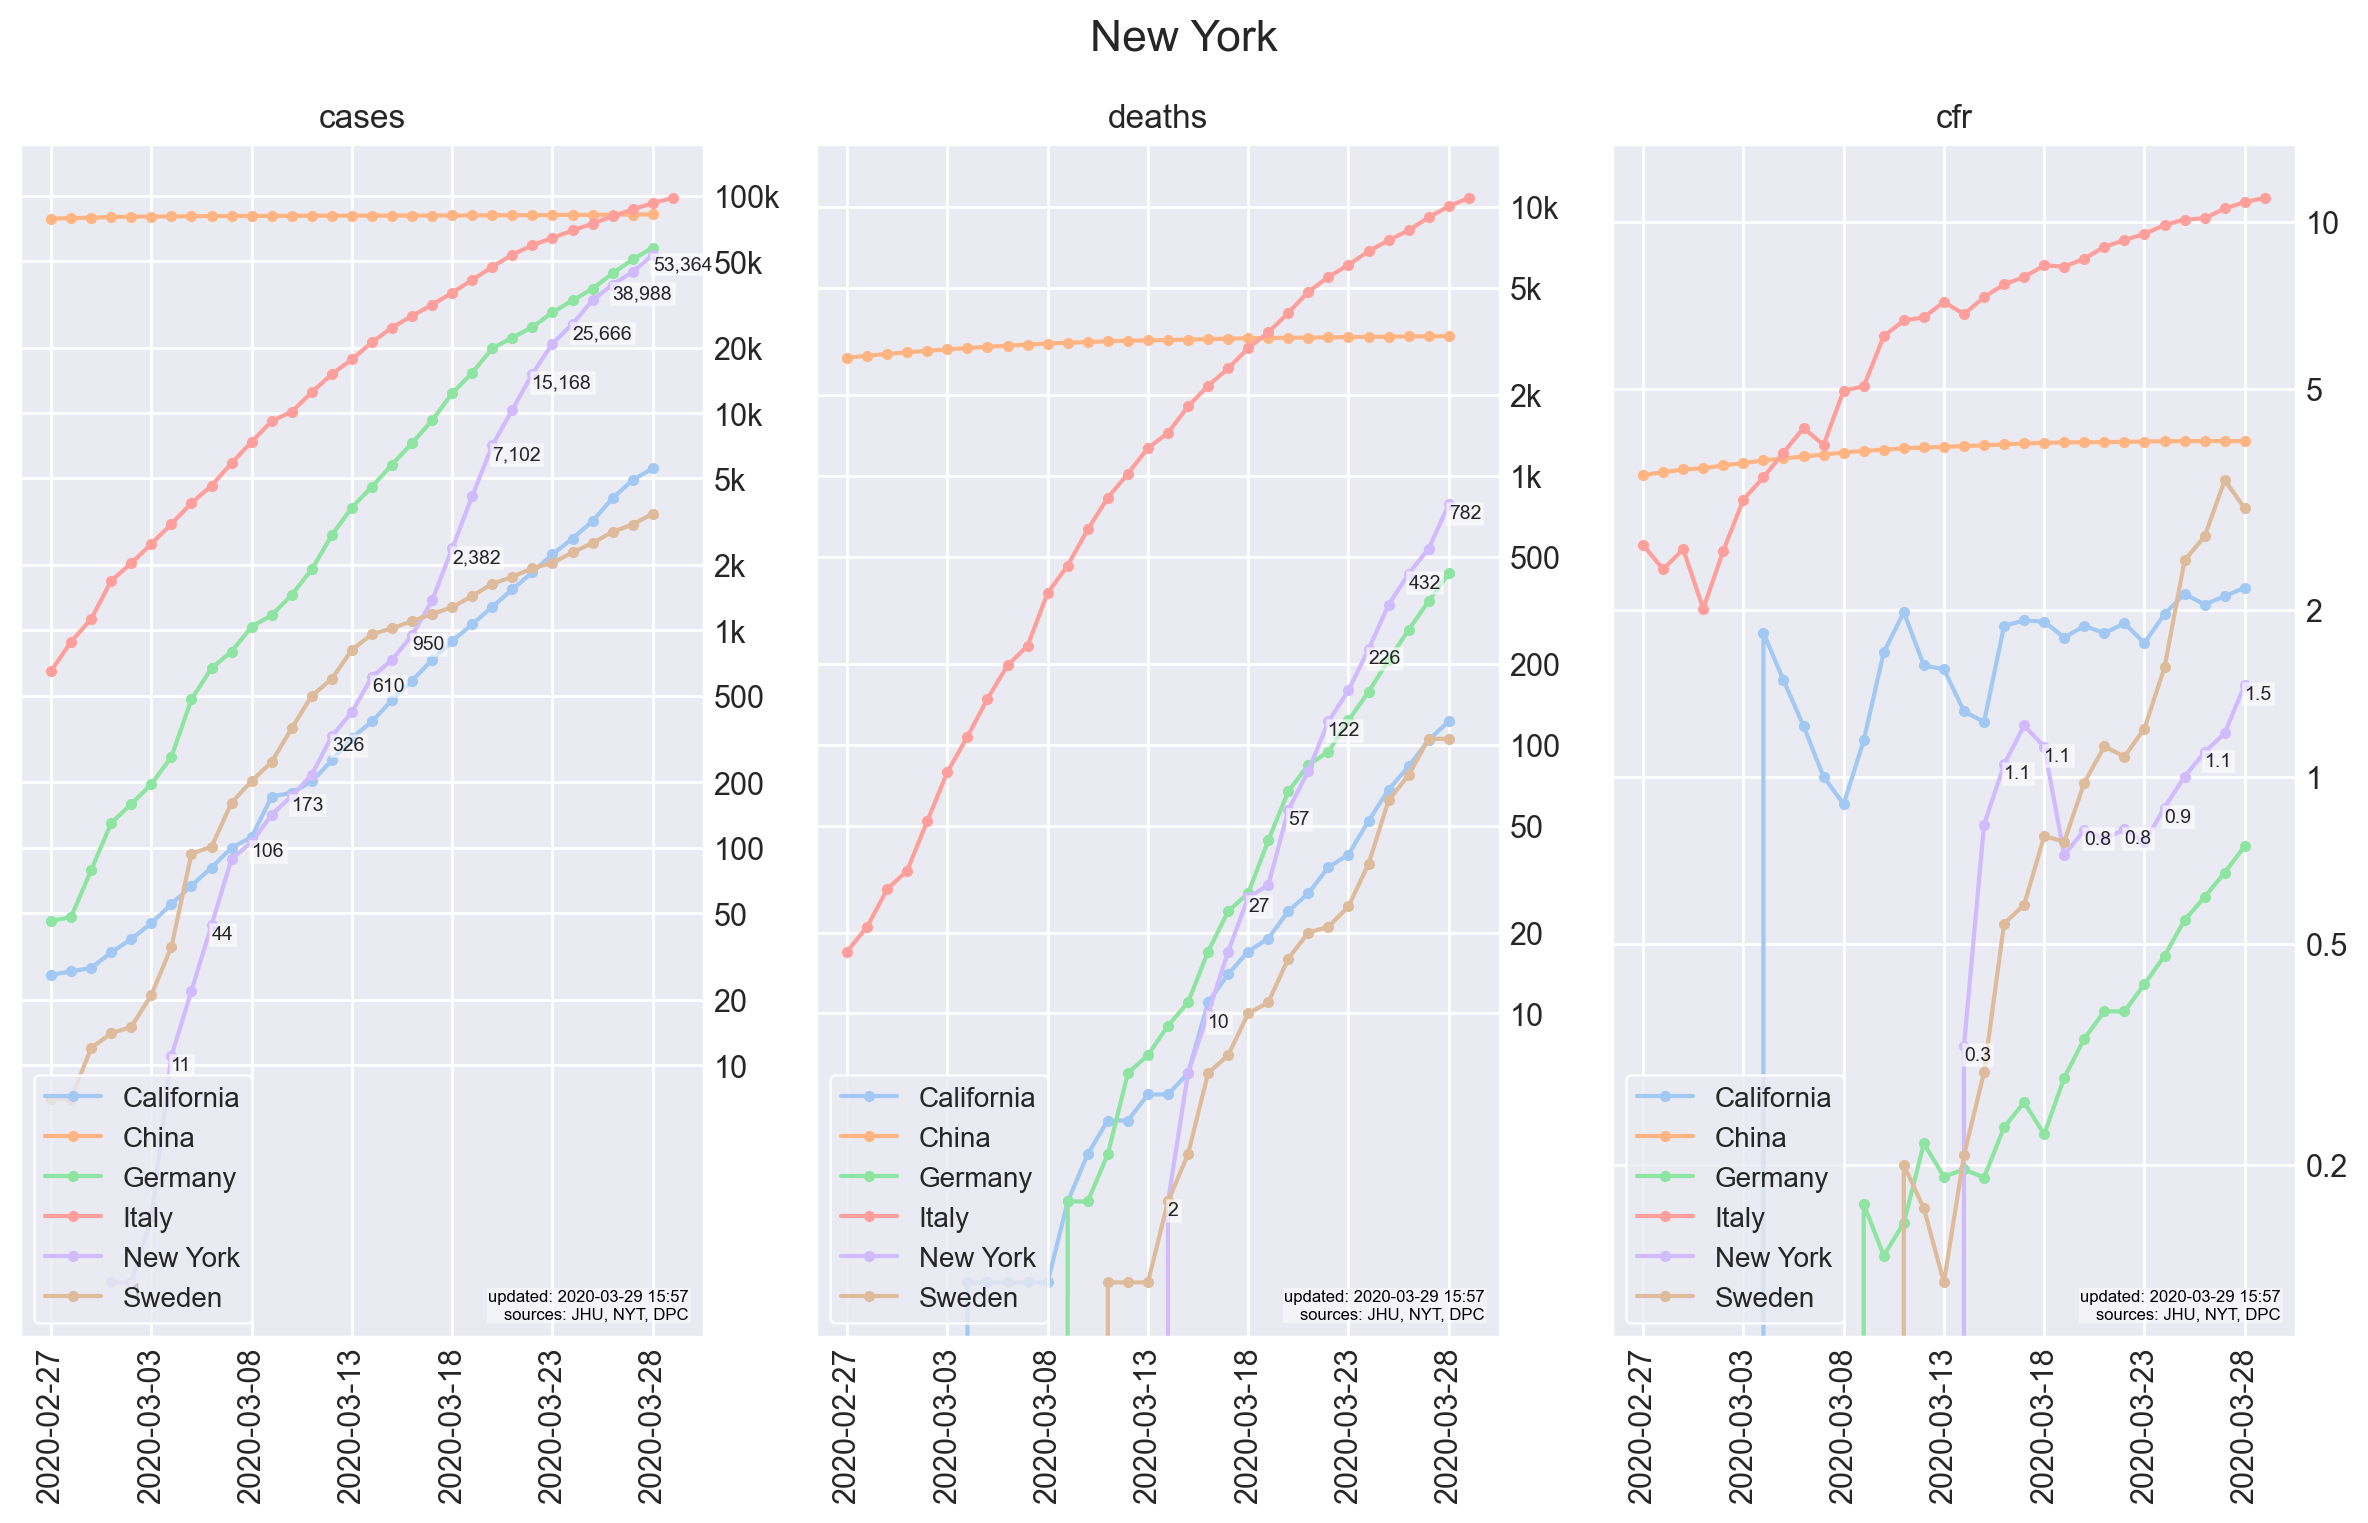

In [14]:
def get_timeseries(df, index, series, country=None, state=None, rollup_states=True):
    df = df.copy()

    if isinstance(country, str):
        country = [country]
    if isinstance(state, str):
        state = [state]

    df_country = df.loc[df['country'].isin(country)] if country else pd.DataFrame()

    if country and rollup_states:
        df_country = (
            rollup(df_country, 'country')
            .assign(state=lambda x: x['country'])
            .pipe(with_cfr)
            .pipe(with_diffs)
            .pipe(with_pct_change)
        )

    df_state = df.loc[df['state'].isin(state)] if state else pd.DataFrame()
    df = pd.concat([df_country, df_state], sort=True)

    df['region'] = df['state'].fillna(df['country'])#.str.lower()
    df = df.pivot(index=index, columns='region', values=series)
    return df


def plot(countries, states, plots, highlight='Italy', dpi=100):

    days = 31
    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    cols = len(plots)
    fig, axs = plt.subplots(1, cols, figsize=(cols * 4, 8), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        series, df = t
        ax = axs[i] if cols > 1 else axs

        ts = get_timeseries(
            df,
            index='day',
            series=series,
            country=countries,
            state=states,
        )[from_date:]

        ax = ts.plot(title=series, legend=True, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        set_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        ax.set_xticklabels(ts.index.values[::5])
        plt.setp(ax.get_xticklabels(), rotation=90)
        
        # data labels
        set_data_labels(ax, ts[highlight], series)

        # info text box
        props = dict(color='black', fontsize=6, multialignment='right')
        box = AnchoredText(infotext('short'), loc=4, frameon=True, pad=0.1,
                           borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=3, prop={'size':10})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if cols > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


eu5 = ['Italy', 'United Kingdom', 'Germany', 'Spain', 'France']
nordics = ['Sweden', 'Denmark', 'Norway', 'Finland']
asia = ['China', 'Korea, South', 'Singapore', 'Japan']
us = ['California', 'New York', 'Washington', 'New Jersey', 'Illinois']

# works best when picking 4-8 countries/states
df = CATALOG['df.derived.state']

plot(
    countries=eu5[:3] + nordics[:1] + asia[:2],
    states=us[:2],
    plots={
        'cases': df,
        'deaths': df,
        'cfr': df,
    },
    **dict(highlight='New York', dpi=200),
)